In [1]:
import sys
sys.path.append('./code')
from importlib import reload

In [22]:
from make_figure4 import *

row_colors = ['lightgreen', 'green', 'orange']

columns_to_names = {
    0 : 'Active 1',
    4 : 'Active 2',
    18 : 'Repressive',
}

row_colors_dict = {
'Active 1' : 'lightgreen',
'Active 2' : 'green',
'Repressive' : 'orange',
}

In [3]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [4]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')


(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

# (_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
#     inds_to_region_50kb, all_ind_to_region_50kb,
#     chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

In [5]:
from make_figure4 import *

padding_size = 30
def fetch_mat(cool):
    if 'chr' not in chrom1:
        mat = cool.matrix().fetch('chr' + chrom1, 'chr' + chrom2)
    else:
        mat = cool.matrix().fetch(chrom1, chrom2)
    oe_mat = np.exp(normalize_raw_intra(mat, nan_to_zero=False, balance=True))
    padded_mat = np.pad(oe_mat, pad_width=padding_size, mode='constant', constant_values=np.nan)
    return padded_mat
    
def append_mats(cool, name, rows, cols, mat_dict):
    padded_mat = fetch_mat(cool)
    for row, col in zip(rows, cols):
        row, col = row+padding_size, col+padding_size
        submat = padded_mat[row-30:row+30, col-30:col+30]
        # print(submat.shape, padded_mat.shape, row, col)
        # assert submat.shape == (31, 31), (submat.shape, row, col, padded_mat.shape)
        mat_dict[name].append(submat)

In [6]:
megaloop_mat_pref = './megaloop_prominent_peak_output'

treg_mat = np.load(f'{megaloop_mat_pref}/treg_res=50000_intrachromosomal_chrL=1_chrR=1_collapsed_logp_mat.npy')
tcon_mat = np.load(f'{megaloop_mat_pref}/tcon_res=50000_intrachromosomal_chrL=1_chrR=1_collapsed_logp_mat.npy')

In [142]:
X, Y = np.where(treg_mat + tcon_mat > 0)

idx = np.abs(X - 1390) < 10
X, Y = X[idx], Y[idx]

anchor_df = pd.DataFrame([X, Y]).T
anchor_df.columns = ['ind1', 'ind2']

In [143]:
pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/'
cooldict = {
    'Ctrl' : cooler.Cooler(pref + 'Ctrl_sgRNA.mcool::/resolutions/50000'),
    'Helios' : cooler.Cooler(pref + 'Helios_sgRNA.mcool::/resolutions/50000'),
}

In [144]:
import itertools

all_mat_dict = defaultdict(list)
all_metadata = []

rows = anchor_df['ind1']
cols = anchor_df['ind2']
chrom1 = chrom2 = '1'
for name, cool in cooldict.items():
    append_mats(cool, name, rows, cols, all_mat_dict)

for row, col in zip(rows, cols):
    all_metadata.append([row, col, row//5, col//5])

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:134: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


In [145]:
for key, v in all_mat_dict.items():
    all_mat_dict[key] = np.asarray(v)

In [146]:
all_metadata_df = pd.DataFrame(all_metadata)

In [147]:
idx = (all_metadata_df[2]==278)

In [157]:
m1 = scipy.ndimage.gaussian_filter(np.nanmean(all_mat_dict['Helios'][idx], axis=0), sigma=.5)
m2 = scipy.ndimage.gaussian_filter(np.nanmean(all_mat_dict['Ctrl'][idx], axis=0), sigma=.5)

In [158]:
m1 = m1.reshape(30, 2, 30, 2).mean(axis=(1, 3))
m2 = m2.reshape(30, 2, 30, 2).mean(axis=(1, 3))

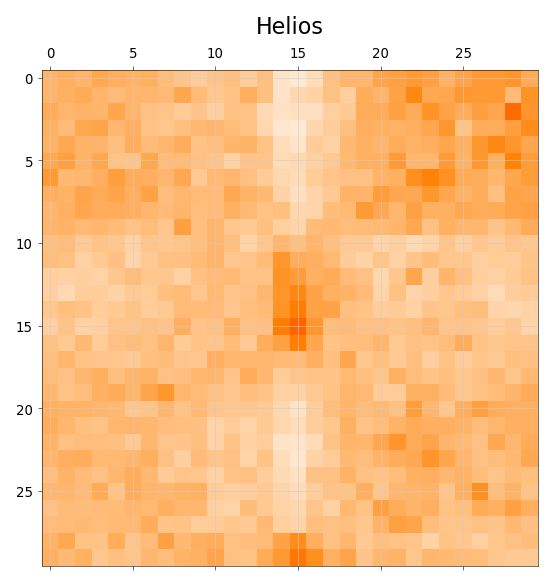

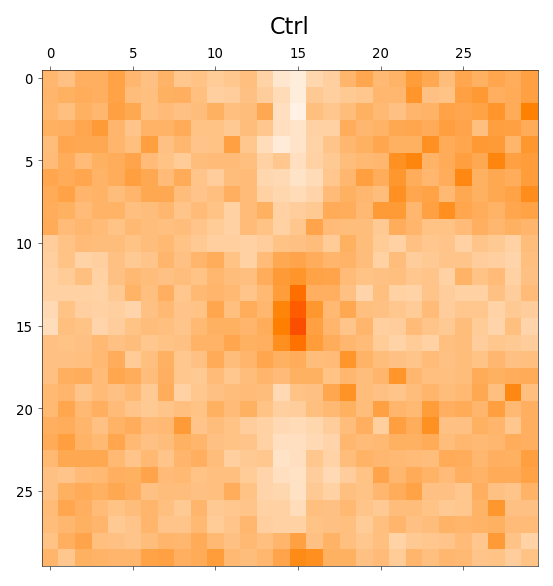

In [163]:
plt.matshow(m1, cmap='gist_heat_r', vmin=0, vmax=10)
plt.title("Helios")
plt.matshow(m2, cmap='gist_heat_r', vmin=0, vmax=10)
plt.title("Ctrl")
plt.grid(False)

In [ ]:
PARSED_CHROMS = np.unique([x[0] for x in all_ind_to_region])

In [11]:
import make_figure4
reload(make_figure4)
from make_figure4 import *
import pickle

goodinds = pickle.load(open('./for_snipping/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./for_snipping/merged_clustdict', 'rb'))
merged_inds_to_subset = pickle.load(open('./for_snipping/merged_inds_to_subset', 'rb'))


cooldict_50kb = pickle.load(open('./for_snipping/cooldict_50kb', 'rb'))
ind_to_gene = pickle.load(open('./for_snipping/ind_to_gene', 'rb'))
all_ind_to_region = pickle.load(open('./for_snipping/all_ind_to_region', 'rb'))

my_treg_comp = pickle.load(open('./for_snipping/my_treg_comp', 'rb'))



In [8]:
from initialize import *

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


In [13]:
gene_to_ind = pickle.load(open('gene_to_ind.p', 'rb'))

In [12]:
df = pd.DataFrame([goodinds, merged_clustdict['all']]).T
df = df[df[1].isin(merged_inds_to_subset)]
df.columns = ['ind', 'cluster']
df['chrom'] = [all_ind_to_region[x][0] for x in df['ind'].values]
df['chrom'] = 'chr' + df['chrom']

In [16]:
%autoreload 2
from hub_pileup import *
from compute_differential_hic_hub import *
from collections import defaultdict
from make_figure4 import *
import itertools
import cooler

pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_merged_cools/'
active_rest_hic_dict = {
    'Ctrl' : cooler.Cooler(pref + 'Ctrl_sgRNA.mcool::/resolutions/50000'),
    'Helios' : cooler.Cooler(pref + 'Helios_sgRNA.mcool::/resolutions/50000'),
}

from collections import defaultdict
from make_figure4 import *
from hub_pileup import *
import itertools

megaloop_pileup_cooldict = cooldict_50kb
padding_size = 50

inter_all_mat_dict, inter_all_metadata = pileup_bins_with_hub(df, active_rest_hic_dict, 
                                                              {'chr' + x : y for x, y in chrom_to_start.items()}, 
                                                              None, 
                                                              None, 
                                                              skip_megaloops=True,
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 50_000)

Done with chr10
Done with chr11
Done with chr11
Done with chr12
Done with chr12
Done with chr12
Done with chr13
Done with chr13
Done with chr13
Done with chr13
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr15
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr17
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr18
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr19
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2
Done with chr2


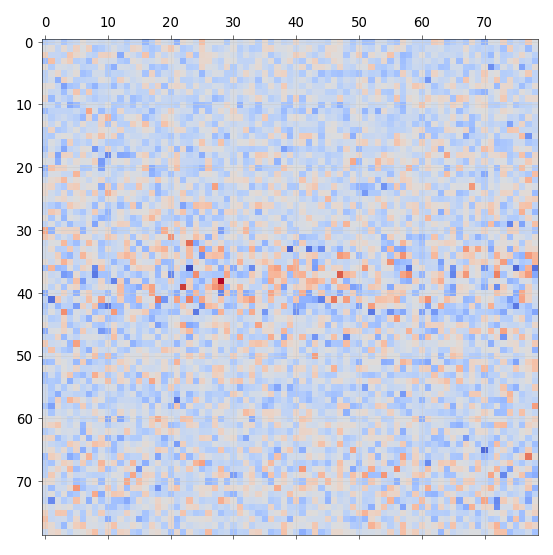

In [43]:
plt.matshow(np.nanmean(mats, axis=2))

(164, 79, 79)
(164, 79, 79)
(279, 79, 79)
(279, 79, 79)
(50, 79, 79)
(50, 79, 79)


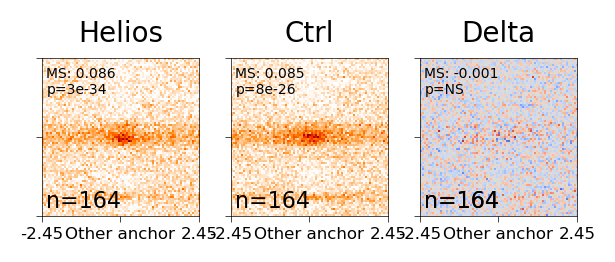

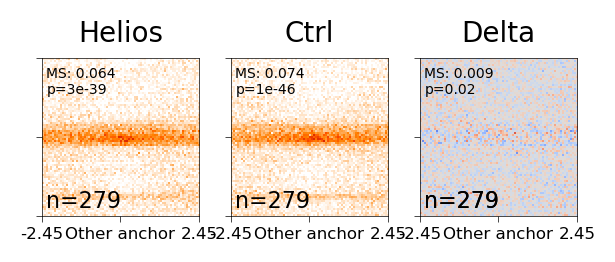

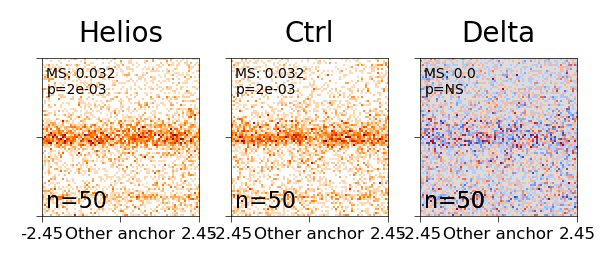

In [48]:
ind = 278
ms = []
name = 'Ikzf2'
for cluster in [4, 0, 18]:
    idx = ( (inter_all_metadata['ind2']==ind) & (inter_all_metadata['cluster1']==cluster)
          )

    rows = []
    keys = [ 'Ctrl',  'Helios']
    keys = [ 'Helios',  'Ctrl']

    fig, axs = init_subplots_exact(3, 1, fgsz=(20*mm, 20*mm), dpi = 100)
    plt.sca(axs[0])

    for c, key in enumerate(keys):
        plt.sca(axs[c])
        mats = np.swapaxes((inter_all_mat_dict[key])[idx][:, 10:-10, 10:-10], 1, 2)
        print(mats.shape)
        plot_pileup_mat(mats, axs[c], cmap = 'gist_heat_r', vmin=-.05, vmax=.25)
        m = np.nanmean(inter_all_mat_dict[key][idx], axis=0)
        ms.append(m)
        n = len(m)//2
        plt.grid(False)
        plt.sca(axs[c])
        plt.title(f'{key}')
    plt.sca(axs[2])
    mats = np.swapaxes((inter_all_mat_dict['Ctrl'][idx] - inter_all_mat_dict['Helios'][idx])[:, 10:-10, 10:-10], 1, 2)
    
    plot_pileup_mat(mats,  axs[2], cmap = 'coolwarm', vmin=-.1, vmax=.1)
    m = np.nanmean(inter_all_mat_dict[key][idx], axis=0)
    ms.append(m)

    plt.title("Delta")
    plt.grid(False)
    plt.text(.03, .05, f'n={idx.sum()}', transform=axs[2].transAxes, fontsize=8)
    
    x1, x2 = all_ind_to_region[5217][1], all_ind_to_region[5217][2]
    xs = np.arange(x1 - 50_000*20, x2 + 50_000*20, 50_000)
    
    cutoff = n*50_000/1e6
    mb = mats.shape[1]*50e3 // 2 / 1e6
    for c, a in enumerate(axs):
        plt.sca(axs[c])

        plt.yticks([-mb, 0, mb])
        plt.gca().set_yticklabels(['', '', ''])
        plt.gca().get_yticklabels()[1].set_fontsize(10)
        plt.gca().get_yticklabels()[1].set_rotation(0)
        plt.gca().get_yticklabels()[1].set_va('center')

        plt.gca().set_xticks([-mb, 0, mb])
        plt.gca().set_xticklabels([-cutoff, "Other anchor", cutoff])

        a.tick_params(labeltop = False, top = False, labelbottom = True, bottom = True)
        if c % n != 0 :
            plt.gca().tick_params(labelleft=False)
    # fig.savefig(f'./plots/GOLNAZ/ets1_Helios_{cluster}.pdf', bbox_inches='tight')

In [ ]:
%autoreload 2
from hub_pileup import pileup_bin_pairs

padding_size = 30

megaloop_pileup_cooldict = cooldict_50kb

df1 = pd.DataFrame()
indsoi = [5217, 5323, 5227, 8682]
df1['ind'] = indsoi
df1['chrom'] = [all_ind_to_region[x][0] for x in df1['ind']]
df1['cluster'] = -1

df2 = pd.DataFrame()
df2['ind'] = goodinds
df2['chrom'] = [all_ind_to_region[x][0] for x in goodinds]
df2['cluster'] = merged_clustdict['all']
df2 = df2[df2['cluster'].isin([0, 4, 18])]


differential_mat_dict, differential_metadata = pileup_bin_pairs(df1, df2, megaloop_pileup_cooldict,
                                                                chrom_to_start, inter_and_intra_connections_treg, 
                                                                inter_and_intra_connections_tcon, 
                                                                resolution_in=250_000, 
                                                                resolution_out = 50_000, 
                                                                intra=False, inter=True, padding_size=padding_size, fetch_oe=True
                                                               )